# Deep Learning Optimization Assignment - Part 1

Momentum-Based Optimizers: SGD, SGD+Momentum, SGD+Nesterov

Students: Complete the sections marked with 'TODO' comments

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import copy
from collections import defaultdict
import gc

# ============================================================================
# CLEAR GPU MEMORY FIRST
# ============================================================================

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    print("✓ GPU memory cleared!")


Using device: cuda
GPU: Tesla P100-PCIE-16GB
Total memory: 17.06 GB
Allocated: 0.00 GB
Cached: 0.00 GB
✓ GPU memory cleared!


## 1. DATA LOADING AND PREPROCESSING

In [10]:
def load_cifar10(batch_size_percentage=100, subset_size=50000, use_accumulation=False):
    """
    Load CIFAR-10 dataset with controllable batch size

    Args:
        batch_size_percentage: Percentage of training data to use per batch
                             100% = Full Batch GD (simulated with accumulation)
                             1-99% = Mini-batch SGD
        subset_size: Number of training samples to use (default: 50000)
        use_accumulation: If True, use smaller physical batches with accumulation
    """
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    ########## TODO ##########
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])


    # Load full dataset
    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Calculate batch size
    total_train_samples = len(trainset_full)
    desired_batch_size = max(1, int(total_train_samples * batch_size_percentage / 100))

    # For gradient accumulation with large batches
    if use_accumulation and desired_batch_size > 500:
        # Use smaller physical batch size and accumulate gradients
        physical_batch_size = 256
        accumulation_steps = max(1, desired_batch_size // physical_batch_size)
        effective_batch_size = physical_batch_size * accumulation_steps

        print(f"Using gradient accumulation:")
        print(f"  Physical batch size: {physical_batch_size}")
        print(f"  Accumulation steps: {accumulation_steps}")
        print(f"  Effective batch size: {effective_batch_size} (~{batch_size_percentage}% of data)")
    else:
        physical_batch_size = desired_batch_size
        accumulation_steps = 1
        effective_batch_size = desired_batch_size
    
    if subset_size < len(trainset_full):
        indices = np.random.choice(len(trainset_full), subset_size, replace=False)
        trainset = Subset(trainset_full, indices)
    else:
        trainset = trainset_full
    
    trainloader = DataLoader(trainset, batch_size=physical_batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    ########## End TODO ##########
    print(f"Batches per epoch: {len(trainloader)}")

    return trainloader, testloader, accumulation_steps

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')


## 2. MODEL DEFINITION (CNN)

In [11]:
class CNNModel(nn.Module):
    """
    CNN for CIFAR-10 - Memory efficient
    """
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        ######### TODO ##########
        # Implement your CNN Architecture
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        ######### End TODO #########

    def forward(self, x):
        ######### TODO ##########
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        ######### End TODO #########
        return x


## 3. CUSTOM OPTIMIZER IMPLEMENTATIONS

In [12]:
class SGDOptimizer:
    """
    Custom SGD optimizer implementation
    Supports: vanilla SGD, SGD+Momentum, SGD+Nesterov Momentum
    """
    def __init__(self, params, lr=0.01, momentum=0.0, nesterov=False, weight_decay=0.0):
        """
        Args:
            params: Model parameters
            lr: Learning rate
            momentum: Momentum factor (0 for vanilla SGD)
            nesterov: Whether to use Nesterov momentum
            weight_decay: L2 regularization factor
        """
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.nesterov = nesterov
        self.weight_decay = weight_decay

        ########## TODO ##########

        # Initialize velocity buffers for momentum
        self.velocity = {p: torch.zeros_like(p.data) for p in self.params}

        ######### End TODO #########

    def zero_grad(self):
        """Clear gradients"""
        ########## TODO ##########
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()
        ######### End TODO #########

    def step(self):
        """Perform optimization step"""
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                ########## TODO ##########
                # Implement the optimization step
                # 1. Get gradient
                # 2. Apply weight decay if self.weight_decay > 0
                # 3. If self.momentum > 0:
                #    a) Update velocity
                #    b) If self.nesterov:
                #       - Apply Nesterov momentum
                #    c) Else (classical momentum)
                # 4. Update parameter

                d_p = p.grad

                # Apply weight decay
                if self.weight_decay != 0:
                    d_p = d_p.add(p, alpha=self.weight_decay)

                # Apply momentum
                if self.momentum != 0:
                    buf = self.velocity[p]
                    buf.mul_(self.momentum).add_(d_p)

                    if self.nesterov:
                        d_p = d_p.add(buf, alpha=self.momentum)
                    else:
                        d_p = buf

                # Update parameters
                p.add_(d_p, alpha=-self.lr)

                ######### End TODO #########


## 4. TRAINING AND EVALUATION FUNCTIONS (WITH GRADIENT ACCUMULATION)

In [13]:
def train_epoch(model, trainloader, optimizer, criterion, device, accumulation_steps=1):
    """
    Train for one epoch with gradient accumulation support

    Args:
        accumulation_steps: Number of batches to accumulate gradients over
                          If > 1, simulates larger batch size
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Track gradient norms
    grad_norms = []

    optimizer.zero_grad()

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        ########## TODO ##########
        # Implement training step with gradient accumulation
        # 1. Forward pass
        # 2. Compute loss
        # 3. Normalize loss by accumulation_steps
        # 4. Backward pass
        # 5. If (batch_idx + 1) % accumulation_steps == 0:
        #    - optimizer.step()
        #    - optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Normalize loss to account for accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # Update weights every accumulation_steps
        if (batch_idx + 1) % accumulation_steps == 0:
            # Calculate gradient norm before optimizer step
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            grad_norms.append(total_norm ** 0.5)

            optimizer.step()
            optimizer.zero_grad()

        ######### End TODO #########

        # Statistics (use original loss for tracking)
        running_loss += loss.item() * accumulation_steps
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Update any remaining gradients
    if (len(trainloader)) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    avg_grad_norm = np.mean(grad_norms) if grad_norms else 0.0

    return epoch_loss, epoch_acc, avg_grad_norm

def evaluate(model, testloader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # Per-class accuracy
    class_correct = [0] * 10
    class_total = [0] * 10

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)

            ########## TODO ##########
            # Implement evaluation step
            # 1. Forward pass
            # 2. Compute loss

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            ######### End TODO #########

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Per-class accuracy
            c = (predicted == targets)
            for i in range(len(targets)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_loss = running_loss / len(testloader)
    test_acc = 100. * correct / total

    per_class_acc = [100. * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                     for i in range(10)]

    return test_loss, test_acc, per_class_acc

def train_model(model, trainloader, testloader, optimizer_name,
                lr, momentum, nesterov, num_epochs, checkpoint_epochs,
                device, accumulation_steps=1):
    """
    Complete training pipeline with checkpointing and gradient accumulation

    Args:
        model: Neural network model
        trainloader: Training data loader
        testloader: Test data loader
        optimizer_name: Name for logging
        lr: Learning rate
        momentum: Momentum factor
        nesterov: Use Nesterov momentum
        num_epochs: Total training epochs
        checkpoint_epochs: List of epochs to save checkpoints
        device: Training device
        accumulation_steps: Gradient accumulation steps

    Returns:
        Dictionary with training history and checkpoints
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = SGDOptimizer(model.parameters(), lr=lr, momentum=momentum,
                            nesterov=nesterov, weight_decay=5e-4)

    # History tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'grad_norms': [],
        'time_per_epoch': [],
        'checkpoints': {},
        'accumulation_steps': accumulation_steps
    }

    print(f"\nTraining with {optimizer_name}")
    print(f"Learning rate: {lr}, Momentum: {momentum}, Nesterov: {nesterov}")
    if accumulation_steps > 1:
        print(f"Gradient accumulation steps: {accumulation_steps}")
    print("=" * 70)

    ########## TODO ##########
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # Train
        train_loss, train_acc, avg_grad_norm = train_epoch(model, trainloader, optimizer, criterion, device, accumulation_steps)

        # Evaluate
        test_loss, test_acc, per_class_acc = evaluate(model, testloader, criterion, device)

        epoch_time = time.time() - start_time
        ########## END TODO ##########

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['grad_norms'].append(avg_grad_norm)
        history['time_per_epoch'].append(epoch_time)

        # Save checkpoint
        if epoch in checkpoint_epochs:
            checkpoint = {
                'epoch': epoch,
                'model_state': copy.deepcopy(model.state_dict()),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'per_class_acc': per_class_acc
            }
            history['checkpoints'][epoch] = checkpoint
            print(f"✓ Checkpoint saved at epoch {epoch}")

        # Print progress
        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | "
                  f"Grad Norm: {avg_grad_norm:.4f} | Time: {epoch_time:.2f}s")

        # Clear cache periodically
        if epoch % 10 == 0:
            torch.cuda.empty_cache()

    print("=" * 70)
    return history


## 5. VISUALIZATION FUNCTIONS

In [14]:
def plot_training_curves(histories, title="Training Curves"):
    """Plot loss and accuracy curves for multiple optimizers"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for name, history in histories.items():
        axes[0, 0].plot(history['train_loss'], label=name, linewidth=2)
        axes[0, 1].plot(history['test_loss'], label=name, linewidth=2)
        axes[1, 0].plot(history['train_acc'], label=name, linewidth=2)
        axes[1, 1].plot(history['test_acc'], label=name, linewidth=2)

    axes[0, 0].set_title('Training Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_title('Test Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].set_title('Training Accuracy', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_title('Test Accuracy', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

def plot_gradient_norms(histories, title="Gradient Norms Over Time"):
    """Plot gradient norms for different optimizers"""
    plt.figure(figsize=(10, 6))

    ########## TODO ##########
    # Plot gradient norms
    # For each optimizer in histories.items()

    for name, history in histories.items():
        plt.plot(history['grad_norms'], label=name)

    ######### End TODO #########

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Average Gradient Norm', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_checkpoint_comparison(histories, checkpoint_epoch):
    """Compare optimizer performance at specific checkpoint"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    names = []
    train_accs = []
    test_accs = []

    for name, history in histories.items():
        if checkpoint_epoch in history['checkpoints']:
            checkpoint = history['checkpoints'][checkpoint_epoch]
            names.append(name)
            train_accs.append(checkpoint['train_acc'])
            test_accs.append(checkpoint['test_acc'])

    x = np.arange(len(names))
    width = 0.35

    axes[0].bar(x, train_accs, width, color='skyblue', edgecolor='black')
    axes[0].set_title(f'Training Accuracy at Epoch {checkpoint_epoch}',
                     fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(names, rotation=45, ha='right')
    axes[0].grid(True, alpha=0.3, axis='y')

    axes[1].bar(x, test_accs, width, color='lightcoral', edgecolor='black')
    axes[1].set_title(f'Test Accuracy at Epoch {checkpoint_epoch}',
                     fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(names, rotation=45, ha='right')
    axes[1].grid(True, alpha=0.3, axis='y')


    plt.tight_layout()
    plt.show()

def plot_per_class_accuracy_heatmap(histories):
    """Create heatmap of per-class accuracy for final epoch"""
    final_epoch_data = []
    optimizer_names = []

    for name, history in histories.items():
        # Get final checkpoint
        final_checkpoint = history['checkpoints'][max(history['checkpoints'].keys())]
        final_epoch_data.append(final_checkpoint['per_class_acc'])
        optimizer_names.append(name)

    ########## TODO ##########
    # Create heatmap using seaborn

    plt.figure(figsize=(12, 6))
    sns.heatmap(final_epoch_data, annot=True, fmt=".1f", cmap="YlGnBu",
                xticklabels=classes, yticklabels=optimizer_names)

    ######### End TODO #########

    plt.title('Per-Class Accuracy Comparison (Final Epoch)',
             fontsize=14, fontweight='bold')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Optimizer', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_time_vs_accuracy(histories):
    """Plot trade-off between training time and accuracy"""
    fig, ax = plt.subplots(figsize=(10, 6))

    for name, history in histories.items():
        total_time = sum(history['time_per_epoch'])
        final_acc = history['test_acc'][-1]

        ########## TODO ##########
        # Create scatter plot
        # Plot total_time vs final_acc for each optimizer

        ax.scatter(total_time, final_acc, s=100, label=name, alpha=0.7)
        ax.text(total_time, final_acc + 0.5, name, fontsize=9)

        ######### End TODO #########

    ax.set_xlabel('Total Training Time (seconds)', fontsize=12)
    ax.set_ylabel('Final Test Accuracy (%)', fontsize=12)
    ax.set_title('Training Time vs Accuracy Trade-off',
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_batch_size_effect_detailed(histories):
    """Detailed analysis of batch size effects"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Extract batch sizes and sort
    batch_info = []
    for name, history in histories.items():
        if 'SGD-' in name:
            batch_pct = int(name.split('-')[1].replace('%', ''))
            batch_info.append((batch_pct, name, history))
    batch_info.sort()

    # Convergence curves
    for batch_pct, name, history in batch_info:
        axes[0, 0].plot(history['test_acc'], label=f'{batch_pct}%', linewidth=2)
    axes[0, 0].set_title('Convergence Speed', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Test Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Final accuracy vs batch size
    batch_sizes = [x[0] for x in batch_info]
    final_accs = [x[2]['test_acc'][-1] for x in batch_info]
    axes[0, 1].plot(batch_sizes, final_accs, 'o-', markersize=10, linewidth=2)
    axes[0, 1].set_title('Final Accuracy vs Batch Size', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Batch Size (%)')
    axes[0, 1].set_ylabel('Final Test Accuracy (%)')
    axes[0, 1].set_xscale('log')
    axes[0, 1].grid(True, alpha=0.3)

    # Training time vs batch size
    total_times = [sum(x[2]['time_per_epoch']) for x in batch_info]
    axes[1, 0].plot(batch_sizes, total_times, 's-', markersize=10, linewidth=2, color='green')
    axes[1, 0].set_title('Total Training Time vs Batch Size', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Batch Size (%)')
    axes[1, 0].set_ylabel('Total Time (seconds)')
    axes[1, 0].set_xscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # Gradient noise (stability)
    noise_levels = [np.std(x[2]['test_acc'][-10:]) for x in batch_info]
    axes[1, 1].plot(batch_sizes, noise_levels, '^-', markersize=10, linewidth=2, color='red')
    axes[1, 1].set_title('Training Stability (Variance in Last 10 Epochs)',
                        fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Batch Size (%)')
    axes[1, 1].set_ylabel('Std Dev of Test Accuracy')
    axes[1, 1].set_xscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Detailed Batch Size Effect Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 6. EXPERIMENT RUNNERS

In [15]:
def experiment_batch_size_effect():
    """
    Experiment 1: Effect of batch size on SGD
    Using gradient accumulation for large batches
    """
    print("\n" + "="*80)
    print("EXPERIMENT 1: BATCH SIZE EFFECT ON SGD")
    print("="*80)

    # Test different effective batch sizes
    batch_percentages = [100, 50, 20, 5, 1]

    num_epochs = 30
    lr = 0.1
    checkpoint_epochs = [5, 10, 20, 30]

    histories = {}

    for batch_pct in batch_percentages:
        print(f"\n--- Training with {batch_pct}% batch size ---")

        # Clear memory before each run
        torch.cuda.empty_cache()
        gc.collect()

        # Load data with gradient accumulation for large batches
        use_accumulation = (batch_pct >= 50)
        trainloader, testloader, accumulation_steps = load_cifar10(
            batch_size_percentage=batch_pct,
            use_accumulation=use_accumulation
        )

        # Create model
        model = CNNModel().to(device)

        # Train
        name = f"SGD-{batch_pct}%"
        ########## TODO ##########
        history = train_model(
            model=model,
            trainloader=trainloader,
            testloader=testloader,
            optimizer_name=name,
            lr=lr,
            momentum=0.0,
            nesterov=False,
            num_epochs=num_epochs,
            checkpoint_epochs=checkpoint_epochs,
            device=device,
            accumulation_steps=accumulation_steps
        )
        ######### End TODO #########

        histories[name] = history

        # Clear model from memory
        del model
        torch.cuda.empty_cache()
        gc.collect()


    # Visualizations
    plot_training_curves(histories, "Batch Size Effect on SGD")
    plot_batch_size_effect_detailed(histories)
    plot_time_vs_accuracy(histories)

    # Comparison table
    print("\n" + "="*80)
    print("BATCH SIZE COMPARISON TABLE")
    print("="*80)
    print(f"{'Batch Size':<15} {'Final Acc':<12} {'Best Acc':<12} {'Total Time':<12} {'Stability':<12}")
    print("-"*80)
    for name, history in histories.items():
        final_acc = history['test_acc'][-1]
        best_acc = max(history['test_acc'])
        total_time = sum(history['time_per_epoch'])
        stability = np.std(history['test_acc'][-10:])
        print(f"{name:<15} {final_acc:<12.2f} {best_acc:<12.2f} {total_time:<12.2f} {stability:<12.2f}")

    return histories

def experiment_momentum_variants():
    """
    Experiment 2: Compare SGD, SGD+Momentum, SGD+Nesterov
    """
    print("\n" + "="*80)
    print("EXPERIMENT 2: MOMENTUM VARIANTS COMPARISON")
    print("="*80)

    num_epochs = 30
    lr = 0.1
    momentum = 0.9
    checkpoint_epochs = [5, 10, 20, 30]
    batch_pct = 1  # Use mini-batch SGD

    # Clear memory
    torch.cuda.empty_cache()
    gc.collect()

    # Load data once
    trainloader, testloader, accumulation_steps = load_cifar10(
        batch_size_percentage=batch_pct,
        use_accumulation=False
    )

    optimizers_config = [
        ("SGD", 0.0, False),
        ("SGD+Momentum", momentum, False),
        ("SGD+Nesterov", momentum, True),
    ]

    histories = {}

    for opt_name, mom, nesterov in optimizers_config:
        print(f"\n--- Training with {opt_name} ---")

        # Clear memory
        torch.cuda.empty_cache()
        gc.collect()

        # Create fresh model
        model = CNNModel().to(device)

        ########## TODO ##########
        # Train
        history = train_model(
            model=model,
            trainloader=trainloader,
            testloader=testloader,
            optimizer_name=opt_name,
            lr=lr,
            momentum=mom,
            nesterov=nesterov,
            num_epochs=num_epochs,
            checkpoint_epochs=checkpoint_epochs,
            device=device,
            accumulation_steps=accumulation_steps
        )
        ######### End TODO #########

        histories[opt_name] = history

        # Clear model
        del model
        torch.cuda.empty_cache()
        gc.collect()


    # Visualizations
    plot_training_curves(histories, "Momentum Variants Comparison")
    plot_gradient_norms(histories, "Gradient Norms: Momentum Variants")

    # Checkpoint comparisons
    for epoch in [10, 40, 80]:
        if epoch in checkpoint_epochs:
            plot_checkpoint_comparison(histories, epoch)

    # Per-class accuracy
    plot_per_class_accuracy_heatmap(histories)

    # Final comparison table
    print("\n" + "="*80)
    print("MOMENTUM VARIANTS FINAL COMPARISON")
    print("="*80)
    print(f"{'Optimizer':<20} {'Final Acc':<12} {'Best Acc':<12} {'Converge@70%':<15}")
    print("-"*80)
    for name, history in histories.items():
        final_acc = history['test_acc'][-1]
        best_acc = max(history['test_acc'])
        # Convergence speed: epoch to reach 70% accuracy
        target = 70.0
        converged_epoch = next((i+1 for i, acc in enumerate(history['test_acc']) if acc >= target), num_epochs)
        print(f"{name:<20} {final_acc:<12.2f} {best_acc:<12.2f} {converged_epoch:<15d}")


    return histories

def experiment_learning_rate_sensitivity():
    """
    Experiment 3: Learning rate sensitivity for each optimizer
    """
    print("\n" + "="*80)
    print("EXPERIMENT 3: LEARNING RATE SENSITIVITY")
    print("="*80)

    num_epochs = 50
    learning_rates = [0.01, 0.1, 0.5]
    momentum = 0.9
    checkpoint_epochs = [10, 25, 50]
    batch_pct = 20

    # Load data once
    trainloader, testloader, accumulation_steps = load_cifar10(
        batch_size_percentage=batch_pct,
        use_accumulation=False
    )

    optimizers_config = [
        ("SGD", 0.0, False),
        ("SGD+Momentum", momentum, False),
        ("SGD+Nesterov", momentum, True),
    ]

    all_histories = {}

    for opt_name, mom, nesterov in optimizers_config:
        print(f"\n{'='*70}")
        print(f"Testing {opt_name} with different learning rates")
        print('='*70)

        for lr in learning_rates:
            print(f"\n--- LR = {lr} ---")

            # Clear memory
            torch.cuda.empty_cache()
            gc.collect()

            # Create fresh model
            model = CNNModel().to(device)

            # Train
            exp_name = f"{opt_name}_LR{lr}"

            ########## TODO ##########
            history = train_model(
                model=model,
                trainloader=trainloader,
                testloader=testloader,
                optimizer_name=exp_name,
                lr=lr,
                momentum=mom,
                nesterov=nesterov,
                num_epochs=num_epochs,
                checkpoint_epochs=checkpoint_epochs,
                device=device,
                accumulation_steps=accumulation_steps
            )
            ######### End TODO #########

            all_histories[exp_name] = history

            # Clear model
            del model
            torch.cuda.empty_cache()
            gc.collect()


    # Group by optimizer type
    for opt_name, _, _ in optimizers_config:
        opt_histories = {k: v for k, v in all_histories.items() if k.startswith(opt_name)}
        plot_training_curves(opt_histories, f"LR Sensitivity: {opt_name}")

    # Summary table
    print("\n" + "="*80)
    print("LEARNING RATE SENSITIVITY SUMMARY")
    print("="*80)
    print(f"{'Optimizer':<25} {'LR':<10} {'Final Acc':<12} {'Best Acc':<12} {'Stable?':<10}")
    print("-"*80)
    for name, history in all_histories.items():
        lr = float(name.split('LR')[1])
        final_acc = history['test_acc'][-1]
        best_acc = max(history['test_acc'])
        # Check stability (low variance in last 10 epochs)
        last_10_var = np.var(history['test_acc'][-10:])
        stable = "Yes" if last_10_var < 2.0 else "No"
        print(f"{name:<25} {lr:<10.2f} {final_acc:<12.2f} {best_acc:<12.2f} {stable:<10}")


    return all_histories


## 7. MAIN EXECUTION

DEEP LEARNING OPTIMIZATION ASSIGNMENT - PART 1
Momentum-Based Optimizers with Gradient Accumulation

[1/3] Running Batch Size Effect Experiment...

EXPERIMENT 1: BATCH SIZE EFFECT ON SGD

--- Training with 100% batch size ---
Using gradient accumulation:
  Physical batch size: 256
  Accumulation steps: 195
  Effective batch size: 49920 (~100% of data)
Batches per epoch: 196

Training with SGD-100%
Learning rate: 0.1, Momentum: 0.0, Nesterov: False
Gradient accumulation steps: 195
Epoch   1/30 | Train Loss: 2.3035 | Train Acc: 10.36% | Test Loss: 2.3013 | Test Acc: 11.32% | Grad Norm: 0.1085 | Time: 11.86s
✓ Checkpoint saved at epoch 5
Epoch   5/30 | Train Loss: 2.2994 | Train Acc: 11.63% | Test Loss: 2.2969 | Test Acc: 14.03% | Grad Norm: 0.0989 | Time: 11.19s
✓ Checkpoint saved at epoch 10
Epoch  10/30 | Train Loss: 2.2948 | Train Acc: 12.73% | Test Loss: 2.2913 | Test Acc: 13.63% | Grad Norm: 0.1047 | Time: 11.47s
Epoch  15/30 | Train Loss: 2.2888 | Train Acc: 13.16% | Test Loss: 2.2

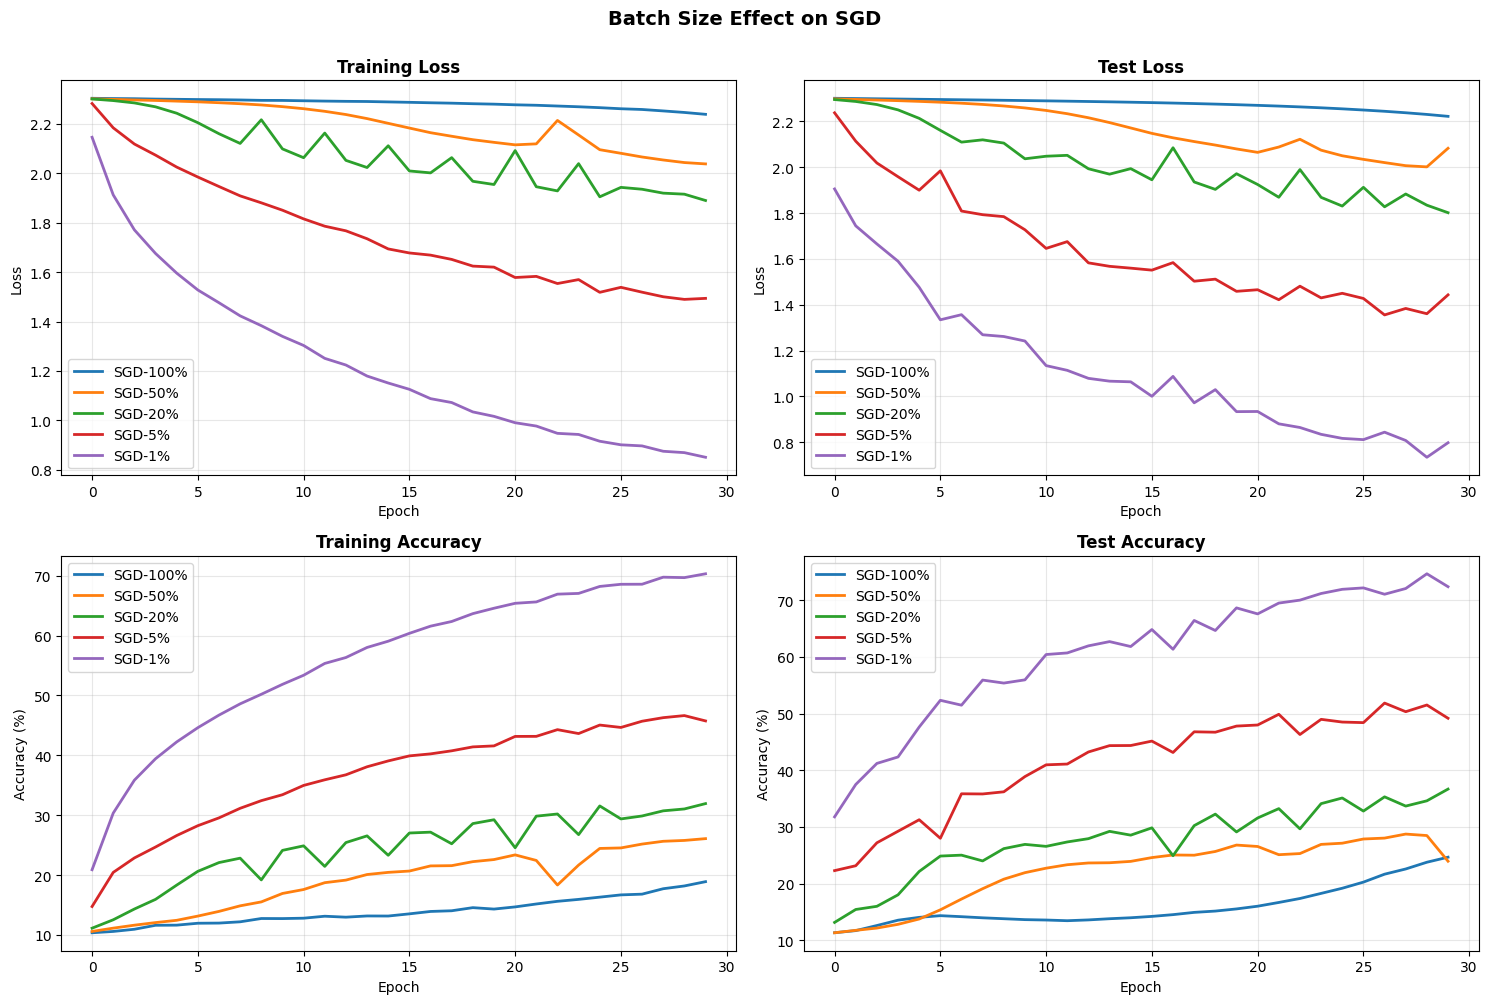

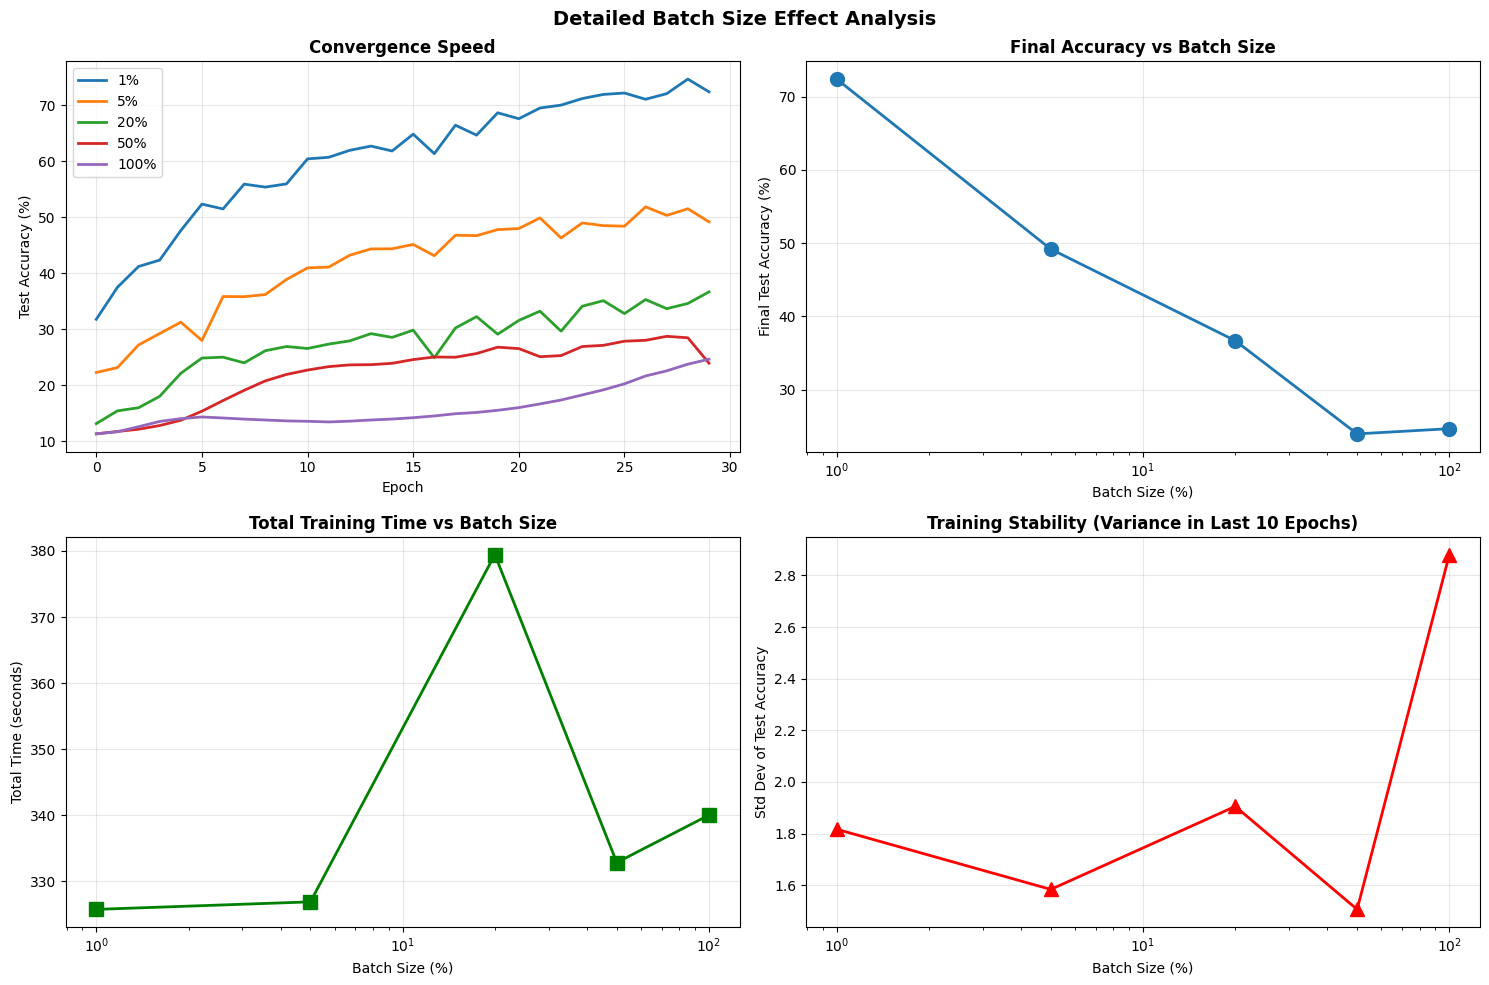

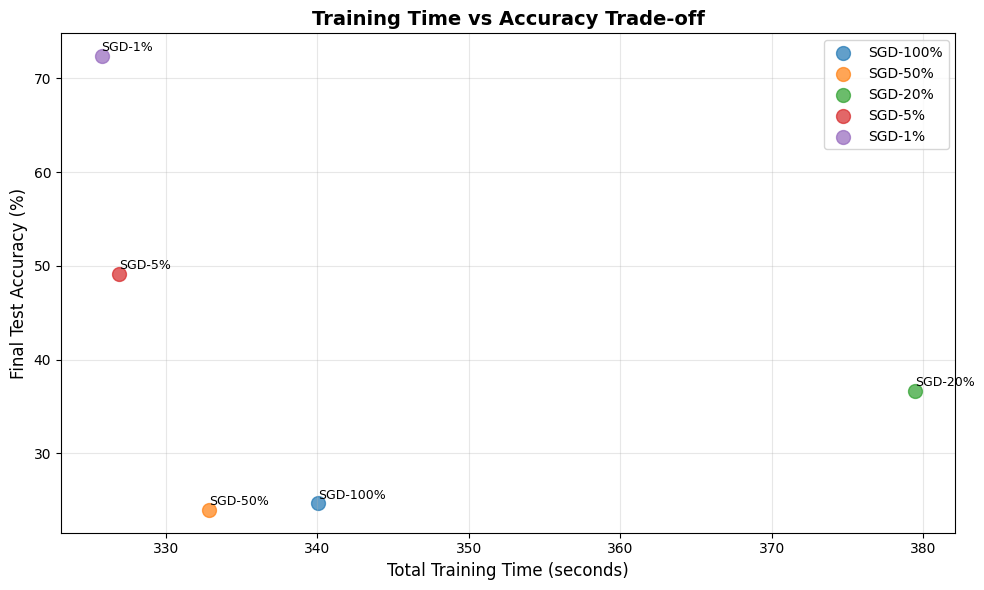


BATCH SIZE COMPARISON TABLE
Batch Size      Final Acc    Best Acc     Total Time   Stability   
--------------------------------------------------------------------------------
SGD-100%        24.65        24.65        340.04       2.88        
SGD-50%         23.94        28.73        332.86       1.51        
SGD-20%         36.67        36.67        379.45       1.91        
SGD-5%          49.17        51.85        326.91       1.58        
SGD-1%          72.39        74.67        325.77       1.82        

[2/3] Running Momentum Variants Comparison...

EXPERIMENT 2: MOMENTUM VARIANTS COMPARISON
Batches per epoch: 100

--- Training with SGD ---

Training with SGD
Learning rate: 0.1, Momentum: 0.0, Nesterov: False
Epoch   1/30 | Train Loss: 2.1423 | Train Acc: 20.83% | Test Loss: 1.9158 | Test Acc: 31.70% | Grad Norm: 0.8813 | Time: 10.84s
✓ Checkpoint saved at epoch 5
Epoch   5/30 | Train Loss: 1.5738 | Train Acc: 42.95% | Test Loss: 1.4080 | Test Acc: 48.15% | Grad Norm: 1.8069 

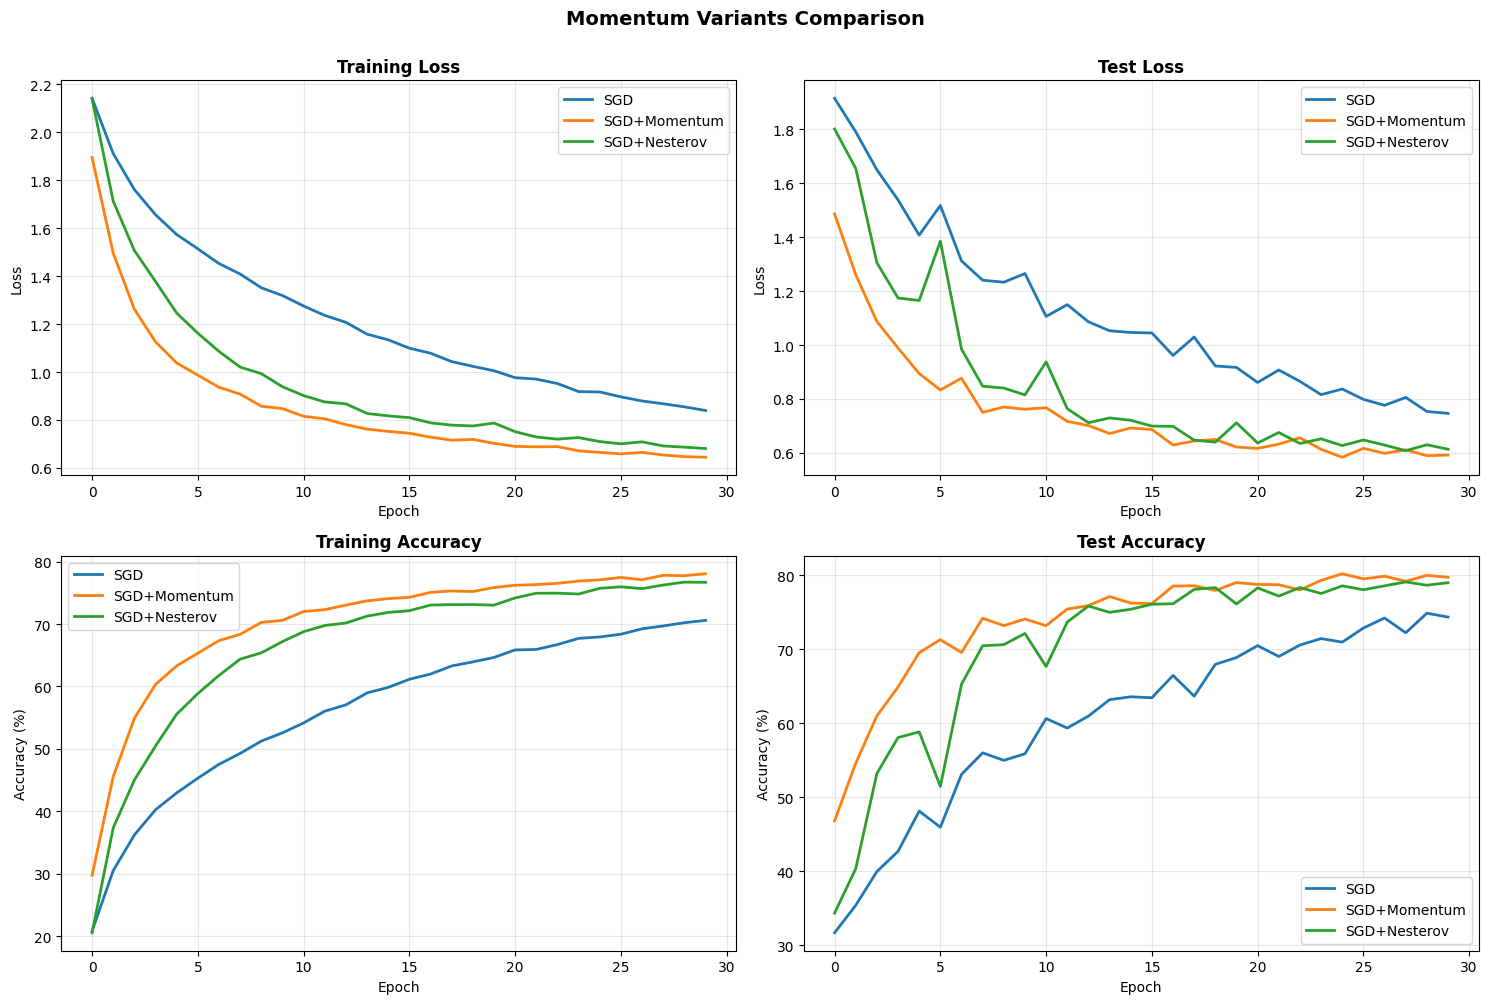

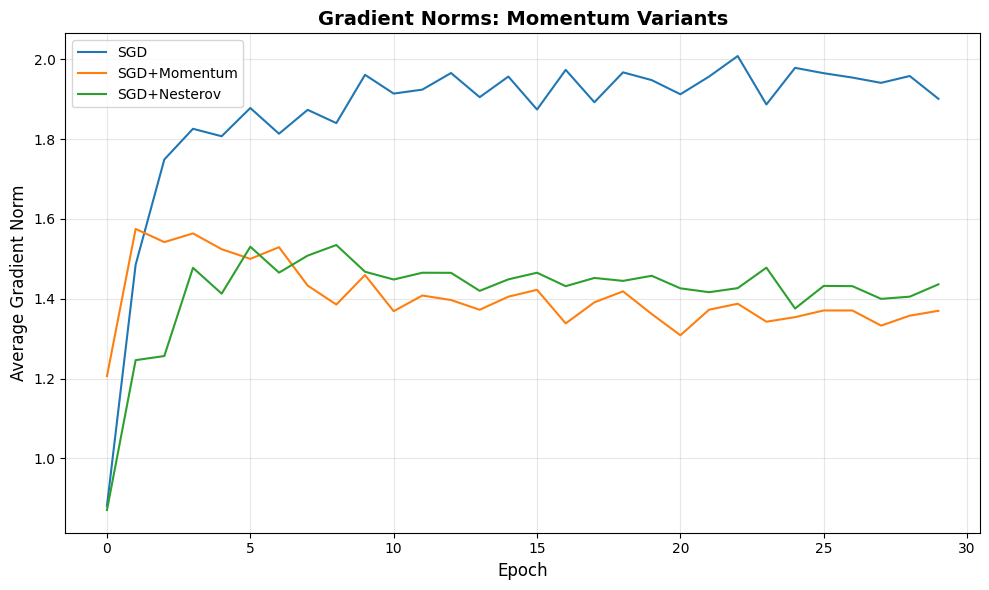

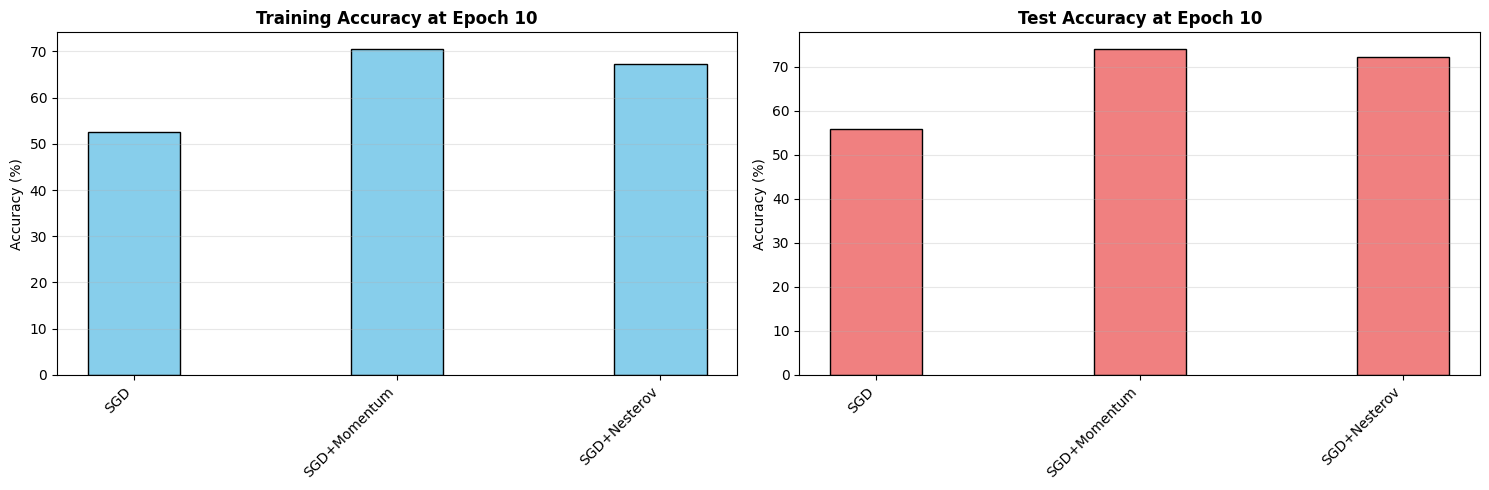

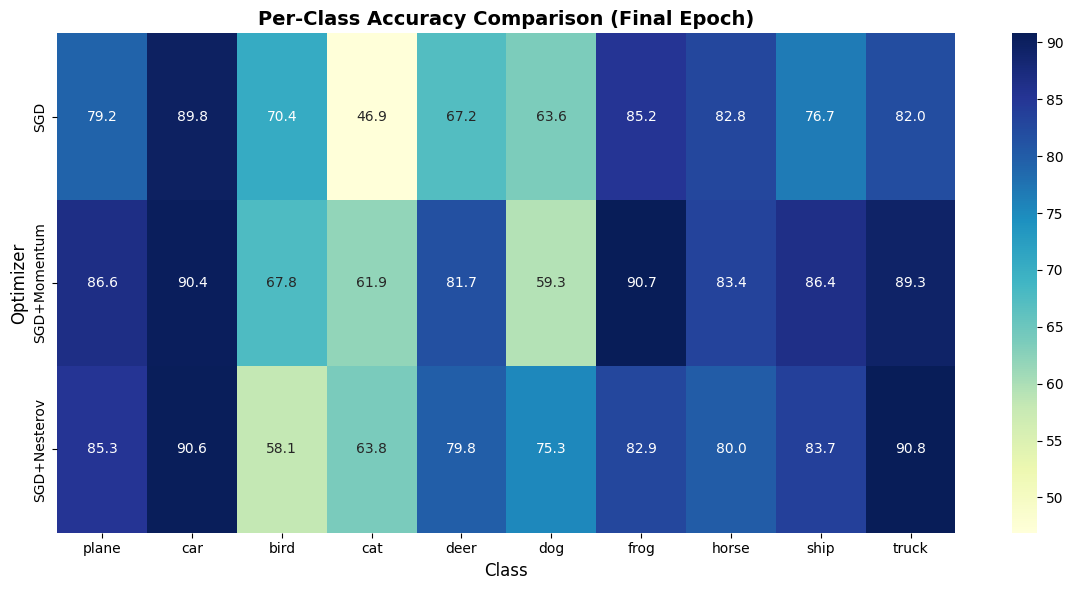


MOMENTUM VARIANTS FINAL COMPARISON
Optimizer            Final Acc    Best Acc     Converge@70%   
--------------------------------------------------------------------------------
SGD                  74.38        74.90        21             
SGD+Momentum         79.75        80.23        6              
SGD+Nesterov         79.03        79.13        8              

[3/3] Running Learning Rate Sensitivity Analysis...

EXPERIMENT 3: LEARNING RATE SENSITIVITY
Batches per epoch: 5

Testing SGD with different learning rates

--- LR = 0.01 ---

Training with SGD_LR0.01
Learning rate: 0.01, Momentum: 0.0, Nesterov: False
Epoch   1/50 | Train Loss: 2.3056 | Train Acc: 9.80% | Test Loss: 2.3045 | Test Acc: 9.99% | Grad Norm: 0.1426 | Time: 12.76s
Epoch   5/50 | Train Loss: 2.3026 | Train Acc: 10.32% | Test Loss: 2.3009 | Test Acc: 10.03% | Grad Norm: 0.1347 | Time: 12.62s
✓ Checkpoint saved at epoch 10
Epoch  10/50 | Train Loss: 2.2985 | Train Acc: 11.03% | Test Loss: 2.2968 | Test Acc: 11.33

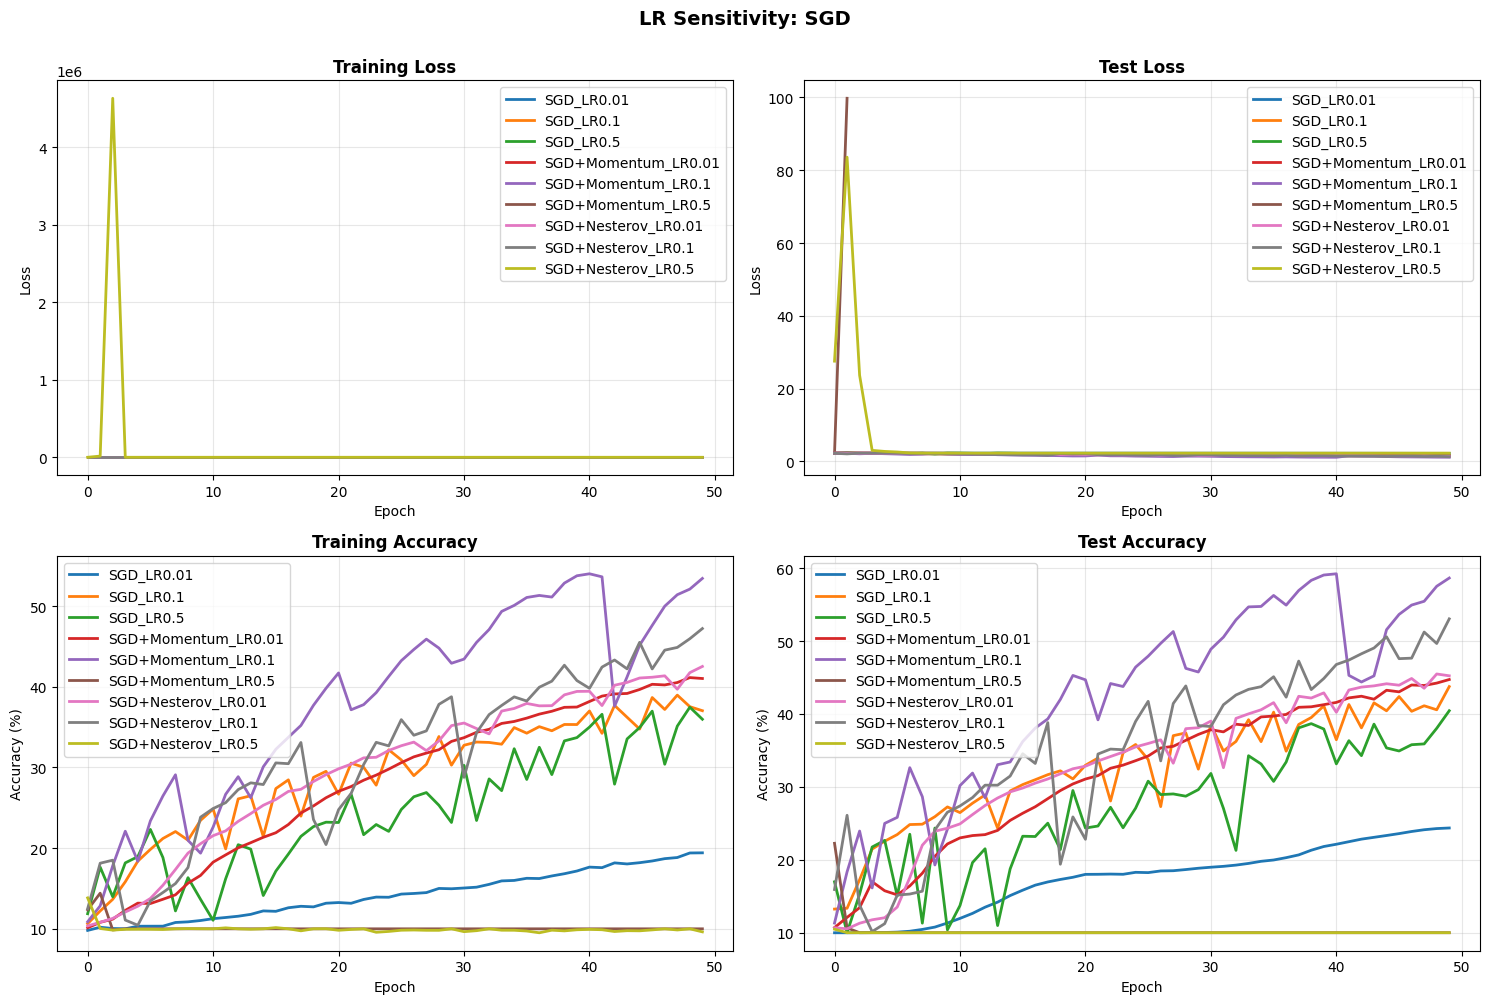

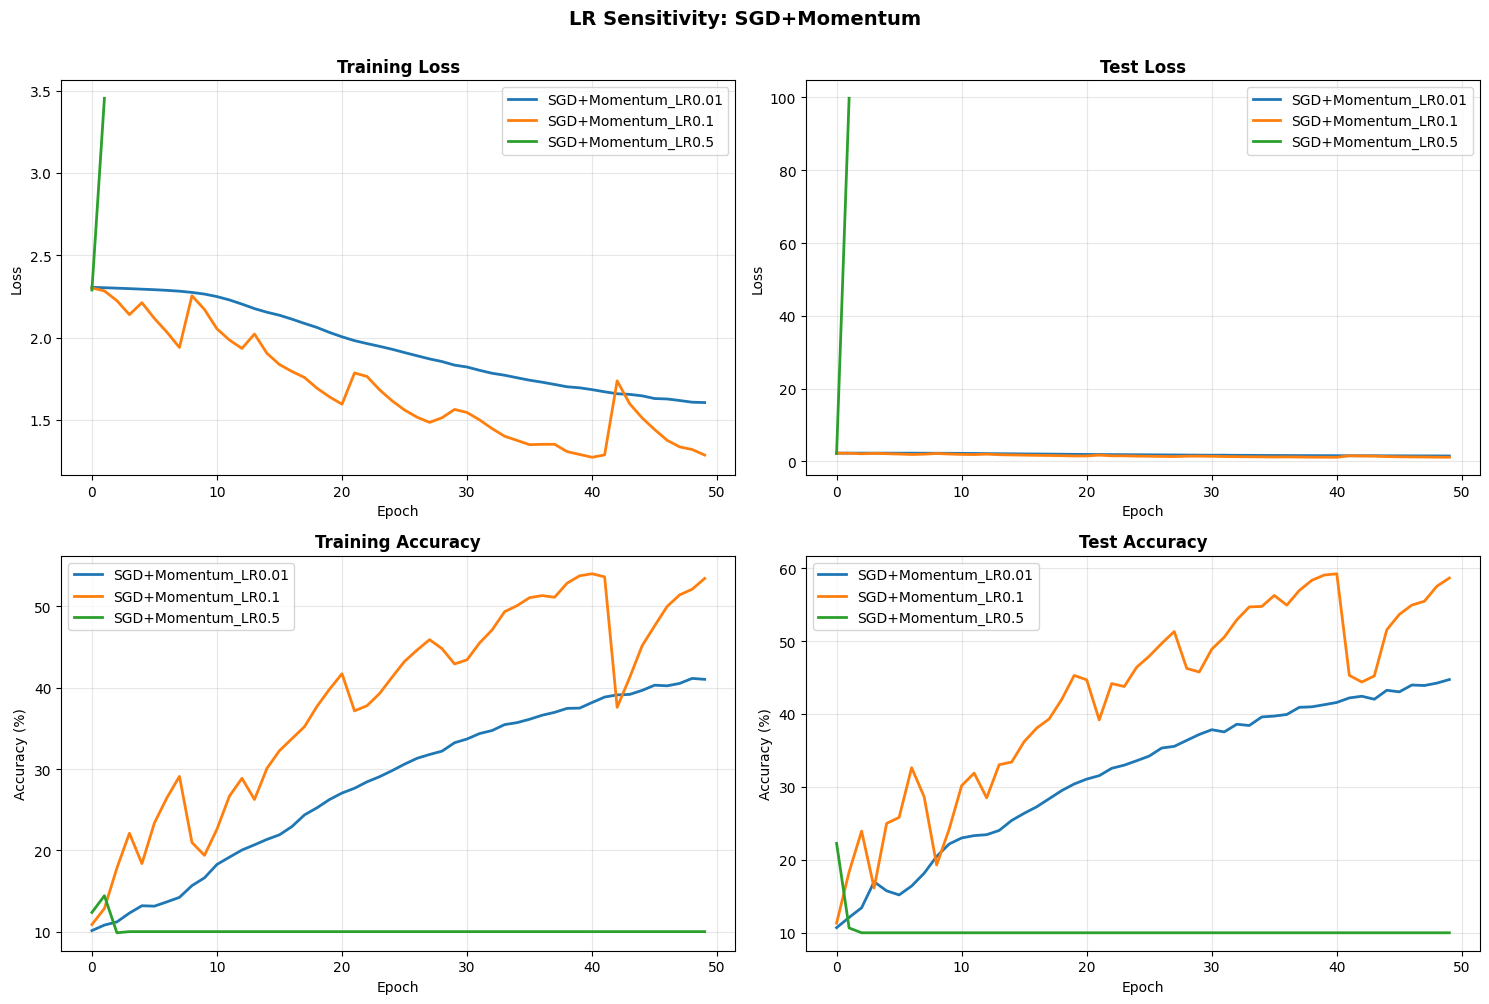

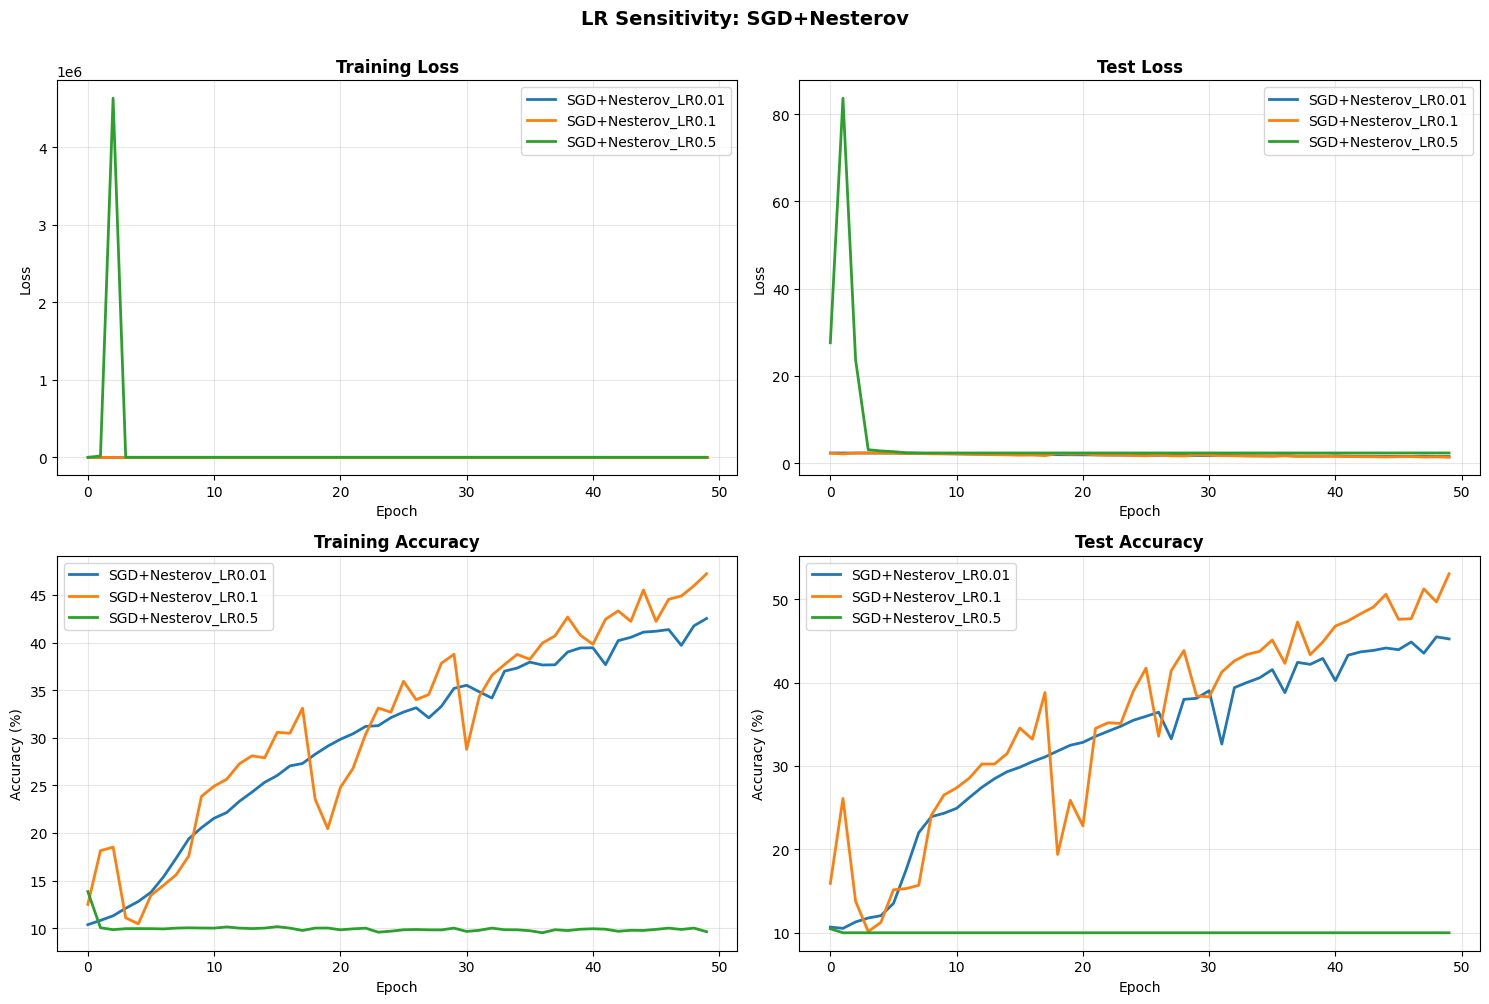


LEARNING RATE SENSITIVITY SUMMARY
Optimizer                 LR         Final Acc    Best Acc     Stable?   
--------------------------------------------------------------------------------
SGD_LR0.01                0.01       24.36        24.36        Yes       
SGD_LR0.1                 0.10       43.75        43.75        No        
SGD_LR0.5                 0.50       40.44        40.44        No        
SGD+Momentum_LR0.01       0.01       44.72        44.72        Yes       
SGD+Momentum_LR0.1        0.10       58.64        59.22        No        
SGD+Momentum_LR0.5        0.50       10.00        22.26        Yes       
SGD+Nesterov_LR0.01       0.01       45.23        45.48        Yes       
SGD+Nesterov_LR0.1        0.10       53.04        53.04        No        
SGD+Nesterov_LR0.5        0.50       10.00        10.48        Yes       

ALL EXPERIMENTS COMPLETED! Review your results and write your report.


In [16]:
if __name__ == "__main__":
    print("="*80)
    print("DEEP LEARNING OPTIMIZATION ASSIGNMENT - PART 1")
    print("Momentum-Based Optimizers with Gradient Accumulation")
    print("="*80)

    # Run experiments
    print("\n[1/3] Running Batch Size Effect Experiment...")
    batch_histories = experiment_batch_size_effect()

    print("\n[2/3] Running Momentum Variants Comparison...")
    momentum_histories = experiment_momentum_variants()

    print("\n[3/3] Running Learning Rate Sensitivity Analysis...")
    lr_histories = experiment_learning_rate_sensitivity()

    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETED! Review your results and write your report.")
    print("="*80)

    # Final memory cleanup
    torch.cuda.empty_cache()
    gc.collect()